In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim

import tqdm.notebook as tqdm
from IPython.display import HTML

from bal import data, layers


In [2]:
class AdaptiveNet(nn.Module):
    def __init__(self, in_features, h_size, out_features):
        super(AdaptiveNet, self).__init__()
        self.fc1 = nn.Linear(in_features, h_size)
        self.ada1 = layers.AdaptiveSize(
            min_size=1,
            max_size=h_size,
            prior_loc=1,
            prior_scale=2,
            temperature=1.0
        )
        self.fc2 = nn.Linear(h_size, out_features)
        self.lik = layers.GaussianLikelihood(scale=0.1)
        self.bayesian_layers = [self.ada1]

    def forward(self, inp):
        out = nn.functional.relu(self.fc1(inp))
        out = self.ada1(out)
        out = self.fc2(out)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(self, n_samples=1, scale=1.0):
        kls = []
        for bl in self.bayesian_layers:
            samples_q = bl.posterior.rsample((n_samples,))
            kls.append(torch.mean(
                bl.posterior.log_prob(samples_q) - bl.prior.log_prob(samples_q)
            ))
        return scale * torch.sum(torch.stack(kls))
        

def geometric_discount(n, i):
    return 2 ** (n - i) / (2 ** n - 1)


def uniform_discount(n, _):
    return 1 / n

In [3]:
def run_step(xs_t, ys_t, opt, net, kl_scale=1.0):
    opt.zero_grad()
    ll = torch.mean(net.log_likelihood(xs_t, ys_t))
    kl = net.kl_qp(scale=kl_scale)
    loss = kl - ll
    loss.backward()
    opt.step()
    stats = {
        "loss": loss.detach().numpy(),
        "data_noise_scale": nn.functional.softplus(net.lik.var_spi_scale.detach()).numpy(),
        "layer_loc": net.ada1.var_loc.detach().numpy(),
        "layer_scale": nn.functional.softplus(net.ada1.var_spi_scale.detach()).numpy()
    }
    return stats

In [26]:
domain = (-2.0, 2.0)
xs, ys = data.generate_1d_regression(
    n_points=1000,
    domain=domain, 
    noise_std=0.1, 
    seed=7
)

In [32]:
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)
net = AdaptiveNet(
    in_features=1,
    h_size=50,
    out_features=1
)
opt = optim.Adam(net.parameters(), lr=1e-3)

In [34]:
n_epochs = 10000
batch_size = 100
pbar = tqdm.tqdm(range(n_epochs))
for i in pbar:
    for j, (x_t, y_t) in enumerate(data.batch_generator(xs_t, ys_t, batch_size, shuffle=True)):
        kl_scale = geometric_discount(len(xs_t) // batch_size, j+1)
        stats = run_step(x_t, y_t, opt, net, kl_scale)
    if i % 100 == 0:
        pbar.set_description_str(
            f"loss: {stats['loss']:4.2f}, " 
            f"l_loc: {stats['layer_loc']:4.2f}, " 
            f"l_scale: {stats['layer_scale']:4.2f}"
        )

KeyboardInterrupt: 

In [35]:
preds_t = [net(torch.linspace(-4.0, 4.0, 1000).reshape(-1, 1)) for i in range(10)]
preds = [ps_t.detach().numpy().squeeze() for ps_t in preds_t]

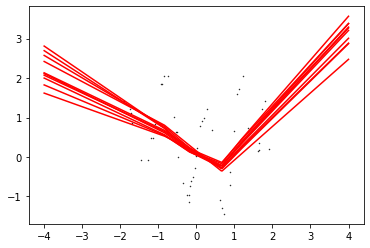

In [36]:
fig, ax = plt.subplots()
ax.scatter(xs, ys, s=0.2, color="black")
for ps in preds:
    ax.plot(np.linspace(domain[0]-2, domain[1]+2, len(ps)), ps, "r-")